## <u>Dart Tab Fusion</u>  

In [1]:
!pip install pytorch_tabnet==4.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 377.4 kB/s eta 0:00:000:00:01


In [8]:
import numpy as np
import polars as pl
import pandas as pd
from pathlib import Path
import json
import os 
import joblib
from datetime import datetime 
from sklearn.metrics import mean_squared_error as mse
# import kaggle_evaluation.mcts_inference_server 

import matplotlib.pyplot as plt
class CFG:
    # Paths to competition data
    train_path = Path('um-game-playing-strength-of-mcts-variants/train.csv')
    test_path = Path('um-game-playing-strength-of-mcts-variants/test.csv')
    subm_path = Path('um-game-playing-strength-of-mcts-variants/sample_submission.csv')
    # Feature engineering (FE) arguments
    batch_size = 16384*2
    low_memory = True
    top_features= True
    drop_gameruleset=True
    version = "dart_5f_V8"
    path =  "mcts-gaurav-dart-tab/"#"/kaggle/working/"#
    infer_path = "mcts-gaurav-dart-tab/dart_5f_V8"
    # Color for EDA and MD
    color = '#E0BFB8' 
    early_stop = 50
    n_features=300
    n_splits = 8
    var_threshold = 0.01#0.005#0.01
    log_steps = 600
    tfidf = False
    DEBUG = False
    single_run = True
    seed=2024
    TRAIN=False
    response_variate='utility_agent1'
    # LightGBM parameters
    lgb_p = {
        'objective': 'regression',
        'boosting_type':'dart',
        'n_estimators': 12000,
        'learning_rate': 0.075,
        'extra_trees': True,
        'reg_lambda': 0.8,
        'colsample_bytree': 0.6,#0.6 
        'subsample': 0.8, 
        'num_leaves': 64,
        'metric': 'rmse',
        'device': 'cpu',
        #'max_depth': 4,
        'max_bin': 128,#128,
        'verbose': -1,
        'seed': 42,
        'num_threads':os.cpu_count(),
    } 

if not os.path.exists(f"{CFG.path}/{CFG.version}"):
    os.makedirs(f"{CFG.path}/{CFG.version}")   

In [9]:
train_path = Path('um-game-playing-strength-of-mcts-variants/train.csv')
test_path = Path('um-game-playing-strength-of-mcts-variants/test.csv')
subm_path = Path('um-game-playing-strength-of-mcts-variants/sample_submission.csv') 

# TRAIN INFER WITH SCRIPTS

In [12]:
import sys
sys.path.insert(0,f'{CFG.path}/{CFG.version}/')  
from fe import FE
from train_infer import MD

In [15]:
top_features = pd.read_csv("mcts-gaurav-dart-tab/lgbm_fe.csv")["name"][:CFG.n_features].to_list()
fe = FE(CFG.batch_size, CFG.low_memory,CFG,top_features)
md = MD(CFG.early_stop, CFG.n_splits,CFG.color,CFG.lgb_p,CFG,top_features)    

def train_model(w):  
    global cat_cols, lgb_models,final_model,drop_cols, lgb_oof_preds,tab_models,lgb_wof_oofs,tab_oofs,cat_models, cat_oofs
    lgb_models_oof=None
    processed_path = f"{CFG.path}/{CFG.version}_processed_train_data.csv"
    cat_cols_path = f"{CFG.path}/{CFG.version}_cat_cols.json"

    if os.path.exists(processed_path+"1"):
        print("Loading processed training data...")
        train = pl.read_csv(processed_path)
        with open(cat_cols_path, 'r') as f:
            cat_cols = json.load(f)
    else:
        print("Processing raw training data...")
        df = pl.read_csv(CFG.train_path, low_memory=CFG.low_memory, batch_size=CFG.batch_size)  
        df = fe.process_agent_cols(df) 
        df = fe.set_datatypes(df)  
        drop_cols = fe.remove_low_variance_features(df, exclude_cols=['utility_agent1','p1_selection','p1_exploration','p2_exploration','p1_playout','p1_bounds','p2_selection','p2_playout','p2_bounds' ])
        train, cat_cols = fe.process_data(df, drop_cols) 
#         train.write_csv(processed_path)
#         with open(cat_cols_path, 'w') as f:
#             json.dump(cat_cols, f)
        print(f"Processed data saved to {processed_path} and cat_cols saved to {cat_cols_path}")
        
    print("#### Columns used ",train.shape, cat_cols)
    cat_models, cat_oofs = md.train_cat(train, cat_cols)      
    lgb_models, lgb_oof_preds,fcls = md.train_lgb(train, cat_cols, '')
    #md.feature_importances(lgb_models,fcls)
    if not CFG.single_run:
        train = train.with_columns(pl.Series(lgb_oof_preds).alias('lgb_oof_preds')) 
        lgb_models_oof, _,_ = md.train_lgb(train, cat_cols, title='_wOOF')
    #md.feature_importances(lgb_models,fcls)
    #train = train.with_columns(pl.Series(lgb_oof_preds).alias('lgb_oof_preds')) 
    #lgb_models_oof, lgb_wof_oofs, _ = md.train_lgb(train, cat_cols, title='LightGBM_wOOF') 
    #tab_models, tab_oofs = md.train_tab(train, cat_cols)      
    score = mse(train[CFG.response_variate],(lgb_oof_preds*w[0]+cat_oofs*w[1]), squared=False)
    print(f"####  Ensemble Score {score} ####")
    
    return lgb_oof_preds

using weights [0.6, 0.4]
Processing raw training data...


/home/hamidme/UM Competition/mcts-gaurav-dart-tab//dart_5f_V8/fe.py:141: CategoricalRemappingWarning:

Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance



Calculating correlation removing more than 0.8
Variable dropped with more than 80.0% 77
Features selected for dropping: 388 
before removal (233234, 867)
after removal (233234, 849)
Shape: (233234, 401)
Memory usage: 356.81 MB

Processed data saved to mcts-gaurav-dart-tab//dart_5f_V8_processed_train_data.csv and cat_cols saved to mcts-gaurav-dart-tab//dart_5f_V8_cat_cols.json
#### Columns used  (233234, 401) ['GameRulesetName', 'agent1_1', 'agent1_2', 'agent1_3', 'agent1_4', 'agent2_1', 'agent2_2', 'agent2_3', 'agent2_4']
using existing fold indicies


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 0 catb CAT CV RMSE: 0.3779538279244822


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 1 catb CAT CV RMSE: 0.4255574828119897


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 2 catb CAT CV RMSE: 0.42624032122814326


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 3 catb CAT CV RMSE: 0.3920211943239598


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 4 catb CAT CV RMSE: 0.3963979069036515


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 5 catb CAT CV RMSE: 0.4384884910786434


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 6 catb CAT CV RMSE: 0.4617225671618552


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 7 catb CAT CV RMSE: 0.39971203196802163

 catb CAT CV RMSE: 0.4155835220680536
using existing fold indicies
X  (233234, 300)
Selected cols 300  Index(['agent2_1', 'agent1_1', 'agent2_3', 'agent1_3', 'agent2_2', 'agent1_2',
       'AdvantageP1', 'agent1_4', 'agent2_4', 'Asymmetric',
       ...
       'ForwardDirection', 'ConcentricTiling', 'Trigger', 'SetSiteState',
       'CanMove', 'FromToEffect', 'SiteState', 'ForwardLeftDirection',
       'MaxMovesInTurn', 'ConnectionEndFrequency'],
      dtype='object', length=300)


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 0 score mse 0.37020029418220257


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 1 score mse 0.41923791788264886


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 2 score mse 0.44259257007934955


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 3 score mse 0.384131818106481


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 4 score mse 0.3888998815080816


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 5 score mse 0.4475221737080596


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 6 score mse 0.45410248284478316
Fold 7 score mse 0.4011905695385448


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



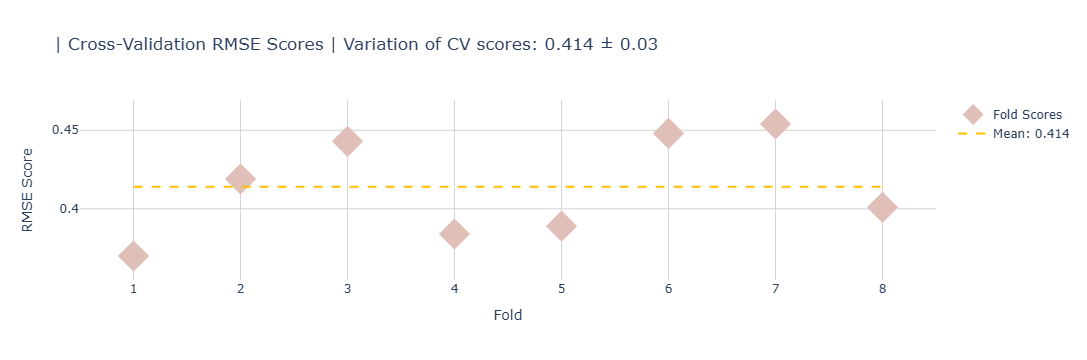

####  Ensemble Score 0.41147718553099877 ####


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [16]:
wts = [0.6,0.4]
print(f"using weights {wts}")
oof_original = train_model(wts)

In [19]:
pd.Series(oof_original).to_csv("oof_original_lgbm.csv",index=False)

In [24]:
top_features = pd.read_csv("mcts-gaurav-dart-tab/lgbm_fe.csv")["name"][:CFG.n_features].to_list()
fe = FE(CFG.batch_size, CFG.low_memory,CFG,top_features)
md = MD(CFG.early_stop, CFG.n_splits,CFG.color,CFG.lgb_p,CFG,top_features)    

def train_model(w):  
    global cat_cols, lgb_models,final_model,drop_cols, lgb_oof_preds,tab_models,lgb_wof_oofs,tab_oofs,cat_models, cat_oofs
    lgb_models_oof=None
    processed_path = f"{CFG.path}/{CFG.version}_processed_train_data.csv"
    cat_cols_path = f"{CFG.path}/{CFG.version}_cat_cols.json"

    if os.path.exists(processed_path+"1"):
        print("Loading processed training data...")
        train = pl.read_csv(processed_path)
        with open(cat_cols_path, 'r') as f:
            cat_cols = json.load(f)
    else:
        print("Processing raw training data...")
        df = pl.read_csv(CFG.train_path, low_memory=CFG.low_memory, batch_size=CFG.batch_size)  
        df = df.with_columns([
            (1 - pl.col("AdvantageP1")).alias("AdvantageP1"),
            (-pl.col("utility_agent1")).alias("utility_agent1")
        ])
        
        # Swap columns agent1 and agent2
        df = df.with_columns([
            pl.col("agent1").alias("agent2"),
            pl.col("agent2").alias("agent1")
        ])

        
        df = fe.process_agent_cols(df) 
        df = fe.set_datatypes(df)  
        drop_cols = fe.remove_low_variance_features(df, exclude_cols=['utility_agent1','p1_selection','p1_exploration','p2_exploration','p1_playout','p1_bounds','p2_selection','p2_playout','p2_bounds' ])
        train, cat_cols = fe.process_data(df, drop_cols) 
#         train.write_csv(processed_path)
#         with open(cat_cols_path, 'w') as f:
#             json.dump(cat_cols, f)
        print(f"Processed data saved to {processed_path} and cat_cols saved to {cat_cols_path}")
        
    print("#### Columns used ",train.shape, cat_cols)
    cat_models, cat_oofs = md.train_cat(train, cat_cols)      
    lgb_models, lgb_oof_preds,fcls = md.train_lgb(train, cat_cols, '')
    #md.feature_importances(lgb_models,fcls)
    if not CFG.single_run:
        train = train.with_columns(pl.Series(lgb_oof_preds).alias('lgb_oof_preds')) 
        lgb_models_oof, _,_ = md.train_lgb(train, cat_cols, title='_wOOF')
    #md.feature_importances(lgb_models,fcls)
    #train = train.with_columns(pl.Series(lgb_oof_preds).alias('lgb_oof_preds')) 
    #lgb_models_oof, lgb_wof_oofs, _ = md.train_lgb(train, cat_cols, title='LightGBM_wOOF') 
    #tab_models, tab_oofs = md.train_tab(train, cat_cols)      
    score = mse(train[CFG.response_variate],(lgb_oof_preds*w[0]+cat_oofs*w[1]), squared=False)
    print(f"####  Ensemble Score {score} ####")
    
    return lgb_oof_preds

using weights [0.6, 0.4]
Processing raw training data...


/home/hamidme/UM Competition/mcts-gaurav-dart-tab//dart_5f_V8/fe.py:141: CategoricalRemappingWarning:

Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance



Calculating correlation removing more than 0.8
Variable dropped with more than 80.0% 77
Features selected for dropping: 388 
before removal (233234, 867)
after removal (233234, 849)
Shape: (233234, 401)
Memory usage: 356.81 MB

Processed data saved to mcts-gaurav-dart-tab//dart_5f_V8_processed_train_data.csv and cat_cols saved to mcts-gaurav-dart-tab//dart_5f_V8_cat_cols.json
#### Columns used  (233234, 401) ['GameRulesetName', 'agent1_1', 'agent1_2', 'agent1_3', 'agent1_4', 'agent2_1', 'agent2_2', 'agent2_3', 'agent2_4']
using existing fold indicies


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 0 catb CAT CV RMSE: 0.4391114960511333


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 1 catb CAT CV RMSE: 0.47964438304703416


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 2 catb CAT CV RMSE: 0.4362337747844881


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 3 catb CAT CV RMSE: 0.453947372559662


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 4 catb CAT CV RMSE: 0.40132476517842863


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 5 catb CAT CV RMSE: 0.48489913463607254


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 6 catb CAT CV RMSE: 0.480635873799987


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.




 fold 7 catb CAT CV RMSE: 0.4412063340351329

 catb CAT CV RMSE: 0.45292345719579413
using existing fold indicies
X  (233234, 300)
Selected cols 300  Index(['agent2_1', 'agent1_1', 'agent2_3', 'agent1_3', 'agent2_2', 'agent1_2',
       'AdvantageP1', 'agent1_4', 'agent2_4', 'Asymmetric',
       ...
       'ForwardDirection', 'ConcentricTiling', 'Trigger', 'SetSiteState',
       'CanMove', 'FromToEffect', 'SiteState', 'ForwardLeftDirection',
       'MaxMovesInTurn', 'ConnectionEndFrequency'],
      dtype='object', length=300)


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 0 score mse 0.43335988109304274


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 1 score mse 0.47350665328803715


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 2 score mse 0.4342574874544803


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 3 score mse 0.45521280381670215


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 4 score mse 0.40528225571978316


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 5 score mse 0.4722654117447238


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



Fold 6 score mse 0.4822283231858038
Fold 7 score mse 0.446322642232947


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



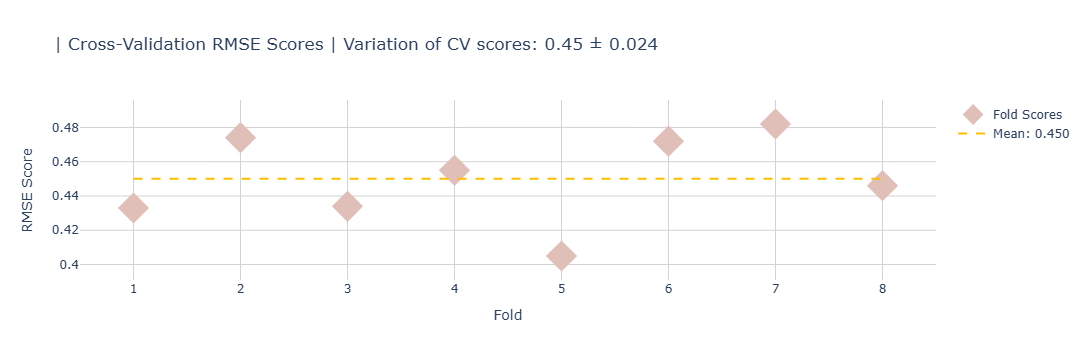

####  Ensemble Score 0.44847111808053247 ####


/home/hamidme/miniconda3/envs/cs323/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [25]:
wts = [0.6,0.4]
print(f"using weights {wts}")
oof_tta = train_model(wts)

In [27]:
pd.Series(oof_tta).to_csv("oof_tta_lgbm.csv",index=False)

# subs

In [8]:
counter = 0  
def predict(test, submission):
    global counter 
    wts = [0.6,0.4]
    print(f"using weights {wts}")
    train_model(wts) if counter == 0 else None
    test = test.to_pandas()
    test_len = len(test)
    # TTA
    temp = test.copy()
    temp['AdvantageP1'] = 1 - temp['AdvantageP1']
    temp['agent1'], temp['agent2'] = temp['agent2'], temp['agent1']
    test = pd.concat([test,temp]).reset_index(drop=True)  
    test = pl.DataFrame(test)    
    counter += 1 
    test = fe.process_agent_cols(test) 
    test = fe.set_datatypes(test)  
    if CFG.tfidf:
        df = fe.do_tfidf(test,True)   
    print("Test shape ",test.shape)  
    
    if CFG.drop_gameruleset: 
        try:
            globals["drop_cols"] = list(globals["drop_cols"] +["GameRulesetName"])
        except BaseException as e:
            print("An exception occurred",e)  
    test, _ = fe.process_data(test, drop_cols +["GameRulesetName"] if CFG.drop_gameruleset else drop_cols, False) 
    return submission.with_columns(pl.Series('utility_agent1', md.inference(test,cat_cols,lgb_models,cat_models,None,test_len,wts))) 

In [9]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)
if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/um-game-playing-strength-of-mcts-variants/test.csv',
            '/kaggle/input/um-game-playing-strength-of-mcts-variants/sample_submission.csv'
        )
    )

using weights [0.6, 0.4]
Processing raw training data...


/kaggle/input/mcts-gaurav-dart-tab//dart_5f_V8/fe.py:141: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  df = df.with_columns([pl.col(col).cast(pl.Categorical) for col in cat_cols if col in df.columns])


Calculating correlation removing more than 0.8
Variable dropped with more than 80.0% 77
Features selected for dropping: 388 
before removal (233234, 867)
after removal (233234, 849)
Shape: (233234, 401)
Memory usage: 356.81 MB

Processed data saved to /kaggle/input/mcts-gaurav-dart-tab//dart_5f_V8_processed_train_data.csv and cat_cols saved to /kaggle/input/mcts-gaurav-dart-tab//dart_5f_V8_cat_cols.json
#### Columns used  (233234, 401) ['GameRulesetName', 'agent1_1', 'agent1_2', 'agent1_3', 'agent1_4', 'agent2_1', 'agent2_2', 'agent2_3', 'agent2_4']
using existing fold indicies

 fold 0 catb CAT CV RMSE: 0.3779538279244822

 fold 1 catb CAT CV RMSE: 0.4255574828119897

 fold 2 catb CAT CV RMSE: 0.42624032122814326

 fold 3 catb CAT CV RMSE: 0.3920211943239598

 fold 4 catb CAT CV RMSE: 0.3963979069036515

 fold 5 catb CAT CV RMSE: 0.4384884910786434

 fold 6 catb CAT CV RMSE: 0.4617225671618552

 fold 7 catb CAT CV RMSE: 0.39971203196802163

 catb CAT CV RMSE: 0.4155835220680536
using 

####  Ensemble Score 0.41147718553099877 ####
Test shape  (6, 816)
An exception occurred 'builtin_function_or_method' object is not subscriptable
before removal (6, 863)
after removal (6, 863)
Shape: (6, 399)
Memory usage: 0.01 MB

done weightage
